<a href="https://colab.research.google.com/github/alon2997/Deep-Learning-Projects/blob/main/%20image_classification_cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Alon Cohen 208955807, Yonatan Pinkas 207002163** ##

## **Imports** ##

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import os

## **Loading the data** ##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "/content/drive/My Drive/Colab Notebooks/cats_and_dogs_data.zip" -d "/content/drive/My Drive/Colab Notebooks/output_folder"

Archive:  /content/drive/My Drive/Colab Notebooks/cats_and_dogs_data.zip
   creating: /content/drive/My Drive/Colab Notebooks/output_folder/content/data/
  inflating: /content/drive/My Drive/Colab Notebooks/output_folder/content/data/X_train.npy  
  inflating: /content/drive/My Drive/Colab Notebooks/output_folder/content/data/Y_test.npy  
  inflating: /content/drive/My Drive/Colab Notebooks/output_folder/content/data/Y_train.npy  
  inflating: /content/drive/My Drive/Colab Notebooks/output_folder/content/data/X_test.npy  


In [ ]:
X_train = np.load('/content/drive/My Drive/Colab Notebooks/output_folder/content/data/X_train.npy')
Y_train = np.load('/content/drive/My Drive/Colab Notebooks/output_folder/content/data/Y_train.npy')
X_test = np.load('/content/drive/My Drive/Colab Notebooks/output_folder/content/data/X_test.npy')
Y_test = np.load('/content/drive/My Drive/Colab Notebooks/output_folder/content/data/Y_test.npy')

## **Exploring the data** ##

In [ ]:
print('Shape of X_train is:', X_train.shape)
print('Shape of Y_train is:', Y_train.shape)
print('Shape of X_test is:', X_test.shape)
print('Shape of Y_test is:', Y_test.shape)
# Each sample is an image of size 180X180 pixels, we have 3200 images for our training set and 800 for our testing set.

Shape of X_train is: (3200, 180, 180, 3)
Shape of Y_train is: (3200,)
Shape of X_test is: (800, 180, 180, 3)
Shape of Y_test is: (800,)


In [ ]:
np.min(X_train), np.max(X_train), X_train.dtype
# Each pixel has integer values ranging from 0 to 255

(0.0, 255.0, dtype('float64'))

In [ ]:
np.min(Y_train), np.max(Y_train), Y_train.dtype
# There are 2 classes in the dataset, represented by the integers 0/1.

(0.0, 1.0, dtype('float64'))

## **Normalize data** ##

In [ ]:
# Normalize data by dividing the data with the maximal value as a float to map it to a range of [0, 1].
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
np.min(X_train), np.max(X_train), X_train.dtype
# After normalizing the min value is 0, the max value is 1.

(0.0, 1.0, dtype('float64'))

<Figure size 432x288 with 0 Axes>

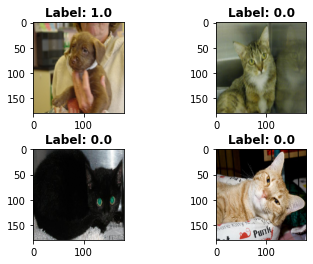

In [ ]:
# Plot some random samples with their labels:
def plot_random_samples(x, y):
  plt.figure()

  f, axarr = plt.subplots(2, 2, gridspec_kw={'hspace':0.4}) 
  rands = np.random.randint(x.shape[0], size=4)
  axarr[0, 0].imshow(x[rands[0], :, :])
  axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow(x[rands[1], :, :])
  axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')

  axarr[0, 1].imshow(x[rands[2], :, :])
  axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')

  axarr[1, 1].imshow(x[rands[3], :, :])
  axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')

  plt.show()

plot_random_samples(X_train, Y_train)

## **Split training data into training vs validation** ##

In [ ]:
# Saving the full training data for the final prediction for our second model
from keras.utils import np_utils
Full_X_train = X_train
Full_Y_train = Y_train
print('Shape of Full_X_train is:', Full_X_train.shape)
print('Shape of Full_Y_train is:', Full_Y_train.shape)

# Change labels to a one-hot format
Full_Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

Shape of Full_X_train is: (3200, 180, 180, 3)
Shape of Full_Y_train is: (3200,)


In [ ]:
# Let's split the training data into training vs validation:
X_train, X_val, Y_train, Y_val = train_test_split(Full_X_train, Full_Y_train, test_size=1/4)
# We chose 1/4 as the split ratio to keep the valdiation and testing sets the same size. 
# After this split we should have 2400 training samples, 800 testing, and 800 validation

In [ ]:
print('Shape of X_train is:', X_train.shape)
print('Shape of Y_train is:', Y_train.shape)
print('Shape of X_test is:', X_test.shape)
print('Shape of Y_test is:', Y_test.shape)
print('Shape of X_val is:', X_val.shape)
print('Shape of Y_val is:', Y_val.shape)
print(Y_train[0, :])

Shape of X_train is: (2400, 180, 180, 3)
Shape of Y_train is: (2400, 2)
Shape of X_test is: (800, 180, 180, 3)
Shape of Y_test is: (800, 2)
Shape of X_val is: (800, 180, 180, 3)
Shape of Y_val is: (800, 2)
[1. 0.]


## **1st model: simple CNN model** ##

In [ ]:
# For our image classification task, we'll use CNNs since they can make spatial connections within the data 
# and give them significance unlike fully connected networks
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout

conv_model = Sequential()
conv_model.add(Input(shape=(180, 180, 3)))

conv_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))

conv_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))

conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu")) 
conv_model.add(MaxPooling2D(pool_size=(2, 2))) 
conv_model.add(Dropout(0.25))

conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu")) 
conv_model.add(MaxPooling2D(pool_size=(2, 2))) 

conv_model.add(Flatten())
conv_model.add(Dense(512, activation="relu")) 
conv_model.add(Dropout(0.5))
conv_model.add(Dense(2, activation="softmax"))



In [ ]:
# We have four convolutional layers and four max pooling layers. 
# In the end we flatten the hidden layers' output and feed it into a final FC output layer.
conv_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [ ]:
conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

conv_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20)

Epoch 1/20
75/75 [==============================] - 18s 105ms/step - loss: 0.7160 - accuracy: 0.5050 - val_loss: 0.6926 - val_accuracy: 0.4863
Epoch 2/20
75/75 [==============================] - 7s 95ms/step - loss: 0.6933 - accuracy: 0.5050 - val_loss: 0.6934 - val_accuracy: 0.4863
Epoch 3/20
75/75 [==============================] - 7s 87ms/step - loss: 0.6932 - accuracy: 0.5117 - val_loss: 0.6893 - val_accuracy: 0.5500
Epoch 4/20
75/75 [==============================] - 7s 95ms/step - loss: 0.6892 - accuracy: 0.5567 - val_loss: 0.6818 - val_accuracy: 0.5650
Epoch 5/20
75/75 [==============================] - 7s 88ms/step - loss: 0.6824 - accuracy: 0.5638 - val_loss: 0.6766 - val_accuracy: 0.5500
Epoch 6/20
75/75 [==============================] - 7s 87ms/step - loss: 0.6588 - accuracy: 0.6004 - val_loss: 0.6731 - val_accuracy: 0.5688
Epoch 7/20
75/75 [==============================] - 7s 94ms/step - loss: 0.6325 - accuracy: 0.6221 - val_loss: 0.6504 - val_accuracy: 0.6175
Epoch 8/20


In [ ]:
y_pred = conv_model.predict(X_test)

In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels))


Accuracy:  0.72


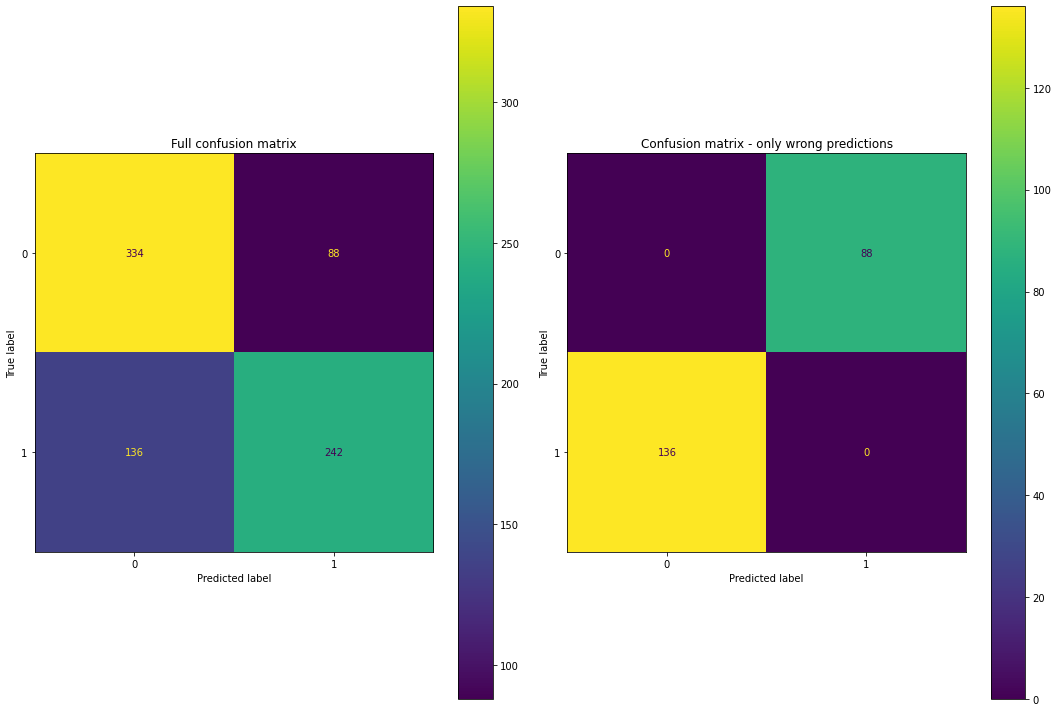

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

martix = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(martix).plot(ax=axes[0])
axes[0].title.set_text('Full confusion matrix')

np.fill_diagonal(martix, 0)
ConfusionMatrixDisplay(martix).plot(ax=axes[1])
axes[1].title.set_text('Confusion matrix - only wrong predictions')

plt.tight_layout()  
plt.show()

<Figure size 432x288 with 0 Axes>

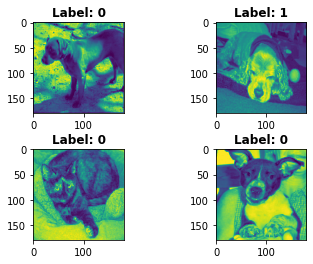

In [ ]:
plot_random_samples(X_test[:, :, :, 0], y_pred_labels)

## **2nd model: our own CNN** ##

For our second model, we chose to go with the original 4 conv layers architecture, but add dropout regularization, image data generation and take some concepts from the resnet architecture. 

Adding dropout layers between each conv layer can help regularize our network and help it generalize better

Using Keras' built in ImageDataGenerator() can help our network generalize better by slightly modifying our input images using rotations, shifts, zooms in and out, rotations and more.

In building our netwrok, we tested different concepts that we borrowed from ResNets architecture, such as 1x1 convolution layers, an initial convolution layer with a bigger kernel, and a final layer of average max pooling into a fully connected layer. After testing, we found that adding the final average pooling layer into a fully connected layer gave us the most significant improvment in testing accuracy.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout

our_conv_model = Sequential()
our_conv_model.add(Input(shape=(180, 180, 3)))


our_conv_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
our_conv_model.add(MaxPooling2D(pool_size=(2, 2)))
our_conv_model.add(Dropout(0.25))

our_conv_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
our_conv_model.add(MaxPooling2D(pool_size=(2, 2)))
our_conv_model.add(Dropout(0.25))

our_conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu")) #
our_conv_model.add(MaxPooling2D(pool_size=(2, 2))) # 
our_conv_model.add(Dropout(0.25))

our_conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu")) #
our_conv_model.add(MaxPooling2D(pool_size=(2, 2))) #
our_conv_model.add(Dropout(0.25))

our_conv_model.add(AveragePooling2D(pool_size = (3, 3)))
our_conv_model.add(Flatten())
our_conv_model.add(Dense(128, activation="relu")) 
our_conv_model.add(Dropout(0.5))
our_conv_model.add(Dense(2, activation="softmax"))



In [ ]:
our_conv_model.summary()
our_conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 43, 43, 64)       

In [ ]:
datagen = ImageDataGenerator(
		rotation_range = 20,
		zoom_range = 0.15,
		width_shift_range = 0.1,
		height_shift_range = 0.1,
		horizontal_flip = True,
		fill_mode = "nearest"
)

datagen.fit(X_train)
our_conv_model.fit(datagen.flow(X_train, Y_train, batch_size= 25), validation_data = (X_val, Y_val), epochs = 35)


Epoch 1/35
96/96 [==============================] - 25s 240ms/step - loss: 0.7027 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4863
Epoch 2/35
96/96 [==============================] - 21s 215ms/step - loss: 0.6926 - accuracy: 0.5171 - val_loss: 0.6931 - val_accuracy: 0.5138
Epoch 3/35
96/96 [==============================] - 21s 215ms/step - loss: 0.6925 - accuracy: 0.5229 - val_loss: 0.6922 - val_accuracy: 0.4938
Epoch 4/35
96/96 [==============================] - 20s 205ms/step - loss: 0.6931 - accuracy: 0.5283 - val_loss: 0.6920 - val_accuracy: 0.5537
Epoch 5/35
96/96 [==============================] - 21s 217ms/step - loss: 0.6888 - accuracy: 0.5400 - val_loss: 0.6902 - val_accuracy: 0.5475
Epoch 6/35
96/96 [==============================] - 20s 205ms/step - loss: 0.6873 - accuracy: 0.5492 - val_loss: 0.6800 - val_accuracy: 0.5675
Epoch 7/35
96/96 [==============================] - 21s 215ms/step - loss: 0.6844 - accuracy: 0.5717 - val_loss: 0.6843 - val_accuracy: 0.5600

In [ ]:
y_pred = our_conv_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels))


Accuracy:  0.78375


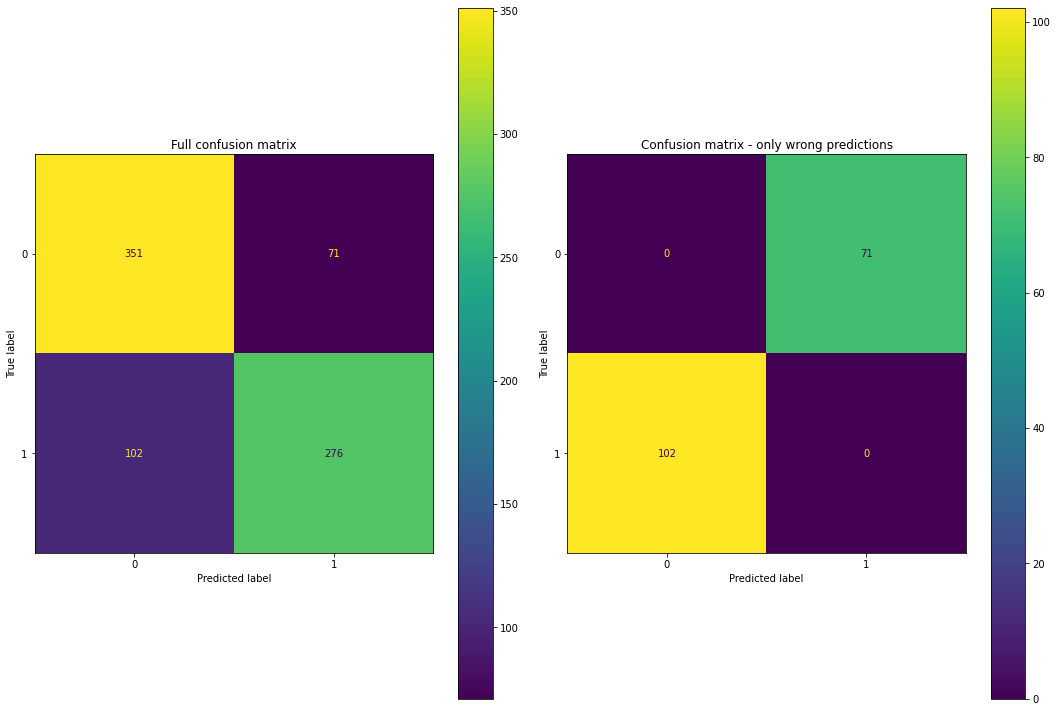

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

martix = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(martix).plot(ax=axes[0])
axes[0].title.set_text('Full confusion matrix')

np.fill_diagonal(martix, 0)
ConfusionMatrixDisplay(martix).plot(ax=axes[1])
axes[1].title.set_text('Confusion matrix - only wrong predictions')

plt.tight_layout()  
plt.show()

In [ ]:
plot_random_samples(X_test[:, :, :, 0], y_pred_labels)

## **3rd model: load a pre-trained model from Keras applications** ##

In [ ]:
# Use the predefined ResNet model
input = tf.keras.Input(shape=(180, 180, 3))

resnet = tf.keras.applications.ResNet50V2(weights="imagenet",
                                          include_top=False, 
                                          input_tensor=input)

# In order to not change resnet's existing weights, we'll set trainable to False
resnet.trainable = False

mid = tf.keras.layers.GlobalMaxPooling2D()(resnet.output)

output = tf.keras.layers.Dense(2, activation='softmax')(mid)

resnet_model = tf.keras.Model(resnet.input, output)

94683136/94668760 [==============================] - 2s 0us/step


In [ ]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 92, 92, 64)   0           ['conv1_conv[0][0]']         

In [ ]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=20)

Epoch 1/20
150/150 [==============================] - 23s 121ms/step - loss: 0.7025 - accuracy: 0.9283 - val_loss: 0.3342 - val_accuracy: 0.9688
Epoch 2/20
150/150 [==============================] - 16s 110ms/step - loss: 0.2667 - accuracy: 0.9671 - val_loss: 0.2999 - val_accuracy: 0.9700
Epoch 3/20
150/150 [==============================] - 18s 122ms/step - loss: 0.1254 - accuracy: 0.9821 - val_loss: 0.3890 - val_accuracy: 0.9675
Epoch 4/20
150/150 [==============================] - 17s 111ms/step - loss: 0.0915 - accuracy: 0.9817 - val_loss: 0.3897 - val_accuracy: 0.9613
Epoch 5/20
150/150 [==============================] - 16s 110ms/step - loss: 0.1797 - accuracy: 0.9758 - val_loss: 0.3948 - val_accuracy: 0.9737
Epoch 6/20
150/150 [==============================] - 18s 119ms/step - loss: 0.1281 - accuracy: 0.9850 - val_loss: 0.3917 - val_accuracy: 0.9750
Epoch 7/20
150/150 [==============================] - 16s 110ms/step - loss: 0.0604 - accuracy: 0.9887 - val_loss: 0.3661 - val_ac

In [ ]:
y_pred = resnet_model.predict(X_test)

In [ ]:
y_pred_labels_application = np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels_application))

Accuracy:  0.97375


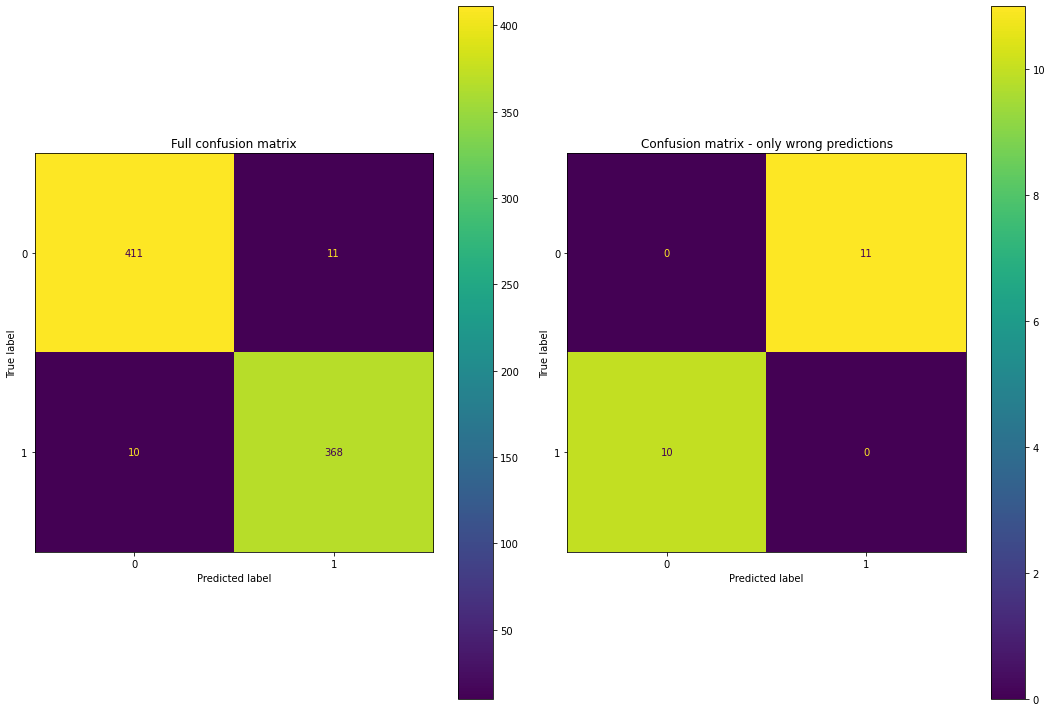

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

martix = confusion_matrix(y_true_labels, y_pred_labels_application)
ConfusionMatrixDisplay(martix).plot(ax=axes[0])
axes[0].title.set_text('Full confusion matrix')

np.fill_diagonal(martix, 0)
ConfusionMatrixDisplay(martix).plot(ax=axes[1])
axes[1].title.set_text('Confusion matrix - only wrong predictions')

plt.tight_layout()  
plt.show()

## **Using full training data to increase the amount of training samples before evaluation on test** ##

In [ ]:
# We'll reload the model to reinitialize all the weights

final_conv_model = Sequential()
final_conv_model.add(Input(shape=(180, 180, 3)))


final_conv_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
final_conv_model.add(MaxPooling2D(pool_size=(2, 2)))
final_conv_model.add(Dropout(0.25))

final_conv_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
final_conv_model.add(MaxPooling2D(pool_size=(2, 2)))
final_conv_model.add(Dropout(0.25))

final_conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu")) 
final_conv_model.add(MaxPooling2D(pool_size=(2, 2))) 
final_conv_model.add(Dropout(0.25))

final_conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu")) 
final_conv_model.add(MaxPooling2D(pool_size=(2, 2))) 
final_conv_model.add(Dropout(0.25))

final_conv_model.add(AveragePooling2D(pool_size = (3, 3)))
final_conv_model.add(Flatten())
final_conv_model.add(Dense(128, activation="relu")) 
final_conv_model.add(Dropout(0.5))
final_conv_model.add(Dense(2, activation="softmax"))
datagen = ImageDataGenerator(
		rotation_range = 20,
		zoom_range = 0.15,
		width_shift_range = 0.1,
		height_shift_range = 0.1,
		horizontal_flip = True,
		fill_mode = "nearest"
)
final_conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
datagen.fit(Full_X_train)
final_conv_model.fit(datagen.flow(Full_X_train, Full_Y_train, batch_size= 25), epochs = 40)


Epoch 1/40
128/128 [==============================] - 36s 207ms/step - loss: 0.6979 - accuracy: 0.5038
Epoch 2/40
128/128 [==============================] - 26s 203ms/step - loss: 0.6919 - accuracy: 0.5284
Epoch 3/40
128/128 [==============================] - 31s 244ms/step - loss: 0.6859 - accuracy: 0.5606
Epoch 4/40
128/128 [==============================] - 28s 219ms/step - loss: 0.6830 - accuracy: 0.5631
Epoch 5/40
128/128 [==============================] - 29s 229ms/step - loss: 0.6835 - accuracy: 0.5581
Epoch 6/40
128/128 [==============================] - 26s 201ms/step - loss: 0.6738 - accuracy: 0.5859
Epoch 7/40
128/128 [==============================] - 27s 214ms/step - loss: 0.6610 - accuracy: 0.5969
Epoch 8/40
128/128 [==============================] - 26s 205ms/step - loss: 0.6436 - accuracy: 0.6363
Epoch 9/40
128/128 [==============================] - 27s 212ms/step - loss: 0.6501 - accuracy: 0.6344
Epoch 10/40
128/128 [==============================] - 27s 207ms/step - l

In [ ]:
y_pred = final_conv_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels))

Accuracy:  0.8475


## **Generate CSV file** ##

In [ ]:
# Keep keys the same, and replace values according to your results and the specified type 

results = {'model': ['Basic CNN', 'My Model', 'ResNet'],
           'Test score (Accuracy)': ['0.72', '0.8475', '0.97375'],
           'Train score (Accuracy)': ['0.9633', '0.8191', '1.00'],
           'Number of trainable parameters': ['5,550,786', '388,674', '23,568,898'],
           'Number of layers': ['4Conv 2FC', '4Conv 2FC', '50'],
           'Regularization methods': ['[MaxPooling, Dropout]', '[MaxPooling, Dropout,AveragePooling]', '[MaxPooling,AveragePooling]'],
           'Number of epochs': ['20', '40', '20'],
           'Loss function': ['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
           'Optimizer': ['adam', 'adam', 'adam']
           }

df = pd.DataFrame(results)
df

,model,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer
0,Basic CNN,0.72,0.9633,"5,550,786",4Conv 2FC,"[MaxPooling, Dropout]",20,categorical_crossentropy,adam
1,My Model,0.8475,0.8191,"388,674",4Conv 2FC,"[MaxPooling, Dropout,AveragePooling]",40,categorical_crossentropy,adam
2,ResNet,0.97375,1.00,"23,568,898",50,"[MaxPooling,AveragePooling]",20,categorical_crossentropy,adam


In [ ]:
from google.colab import files
df.to_csv(os.path.join(os.getcwd(), 'exercise2.csv'))
files.download('exercise2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>